In [1]:
# import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Covid-19 SG dataset details

sheet_id = "1gFTNs_GtnTIyyVWXmsQxwdZpGbyicZM2HJcXvCf4b3k"
sheet_name = "Sheet1"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

In [3]:
# read Covid-19 SG dataset

sg_data = pd.read_csv(url)

In [4]:
# filter to include only columns A to AD

sg_data_filtered = sg_data.iloc[:, :30]

# EDA & Pre-processing

**Outliers will not be removed because of their importance in the Covid context.**

**No need for scaling as all features are of the same magnitude.**

**Can look into what other features can be included from the current ones through extrapolation.**

In [5]:
sg_data_filtered.head()

,Date,Daily Confirmed,False Positives Found,Cumulative Confirmed,Daily Discharged,Passed but not due to COVID,Cumulative Discharged,Discharged to Isolation,Still Hospitalised,Daily Deaths,...,Total Hospital Discharged MOH report,Requires Oxygen Supplementation,Linked community cases,Unlinked community cases,Phase,Cumulative Vaccine Doses,Cumulative Individuals Vaccinated,Cumulative Individuals Vaccination Completed,Perc population completed at least one dose,Perc population completed vaccination
0,2020-01-23,1,NaN,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,2,NaN,3,0,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,1,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,0,NaN,4,0,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,1,NaN,5,0,0,0,0,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Date                                          627 non-null    object 
 1   Daily Confirmed                               627 non-null    int64  
 2   False Positives Found                         518 non-null    float64
 3   Cumulative Confirmed                          627 non-null    int64  
 4   Daily Discharged                              627 non-null    int64  
 5   Passed but not due to COVID                   627 non-null    int64  
 6   Cumulative Discharged                         627 non-null    int64  
 7   Discharged to Isolation                       627 non-null    int64  
 8   Still Hospitalised                            627 non-null    int64  
 9   Daily Deaths                                  627 non-null    int

In [8]:
# convert date to columns: year, month, day before dropping date column

sg_data_filtered["Date"] = pd.to_datetime(sg_data_filtered["Date"])
sg_data_filtered["Year"] = sg_data_filtered["Date"].dt.year
sg_data_filtered["Month"] = sg_data_filtered["Date"].dt.month
sg_data_filtered["Day"] = sg_data_filtered["Date"].dt.day
sg_data_filtered.drop("Date", axis=1, inplace=True)

In [9]:
# convert NaN values for phase to None

sg_data_filtered["Phase"] = sg_data_filtered["Phase"].fillna("None")

In [10]:
# change to one-hot dummy for phase

sg_data_filtered = pd.concat([sg_data_filtered, pd.get_dummies(sg_data_filtered['Phase'], prefix = 'Phase_=')], axis = 1).drop('Phase', axis = 1)

In [11]:
# convert percentage for Perc population completed at least one dose & Perc population completed vaccination

sg_data_filtered["Perc population completed at least one dose"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed at least one dose"]]
sg_data_filtered["Perc population completed vaccination"] = [int(perc.split("%")[0])/100 if type(perc) == str else 0 for perc in sg_data_filtered["Perc population completed vaccination"]]

In [12]:
# convert all NaN values present to zeros for the rest of the columns (if data is unavailable, just treat as 0)

sg_data_filtered.fillna(0, inplace=True)

In [13]:
# check to see if NaN values still present

sg_data_filtered.isnull().values.any()

False

In [14]:
# check column info after pre-processing

sg_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 40 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Daily Confirmed                               627 non-null    int64  
 1   False Positives Found                         627 non-null    float64
 2   Cumulative Confirmed                          627 non-null    int64  
 3   Daily Discharged                              627 non-null    int64  
 4   Passed but not due to COVID                   627 non-null    int64  
 5   Cumulative Discharged                         627 non-null    int64  
 6   Discharged to Isolation                       627 non-null    int64  
 7   Still Hospitalised                            627 non-null    int64  
 8   Daily Deaths                                  627 non-null    int64  
 9   Cumulative Deaths                             627 non-null    int

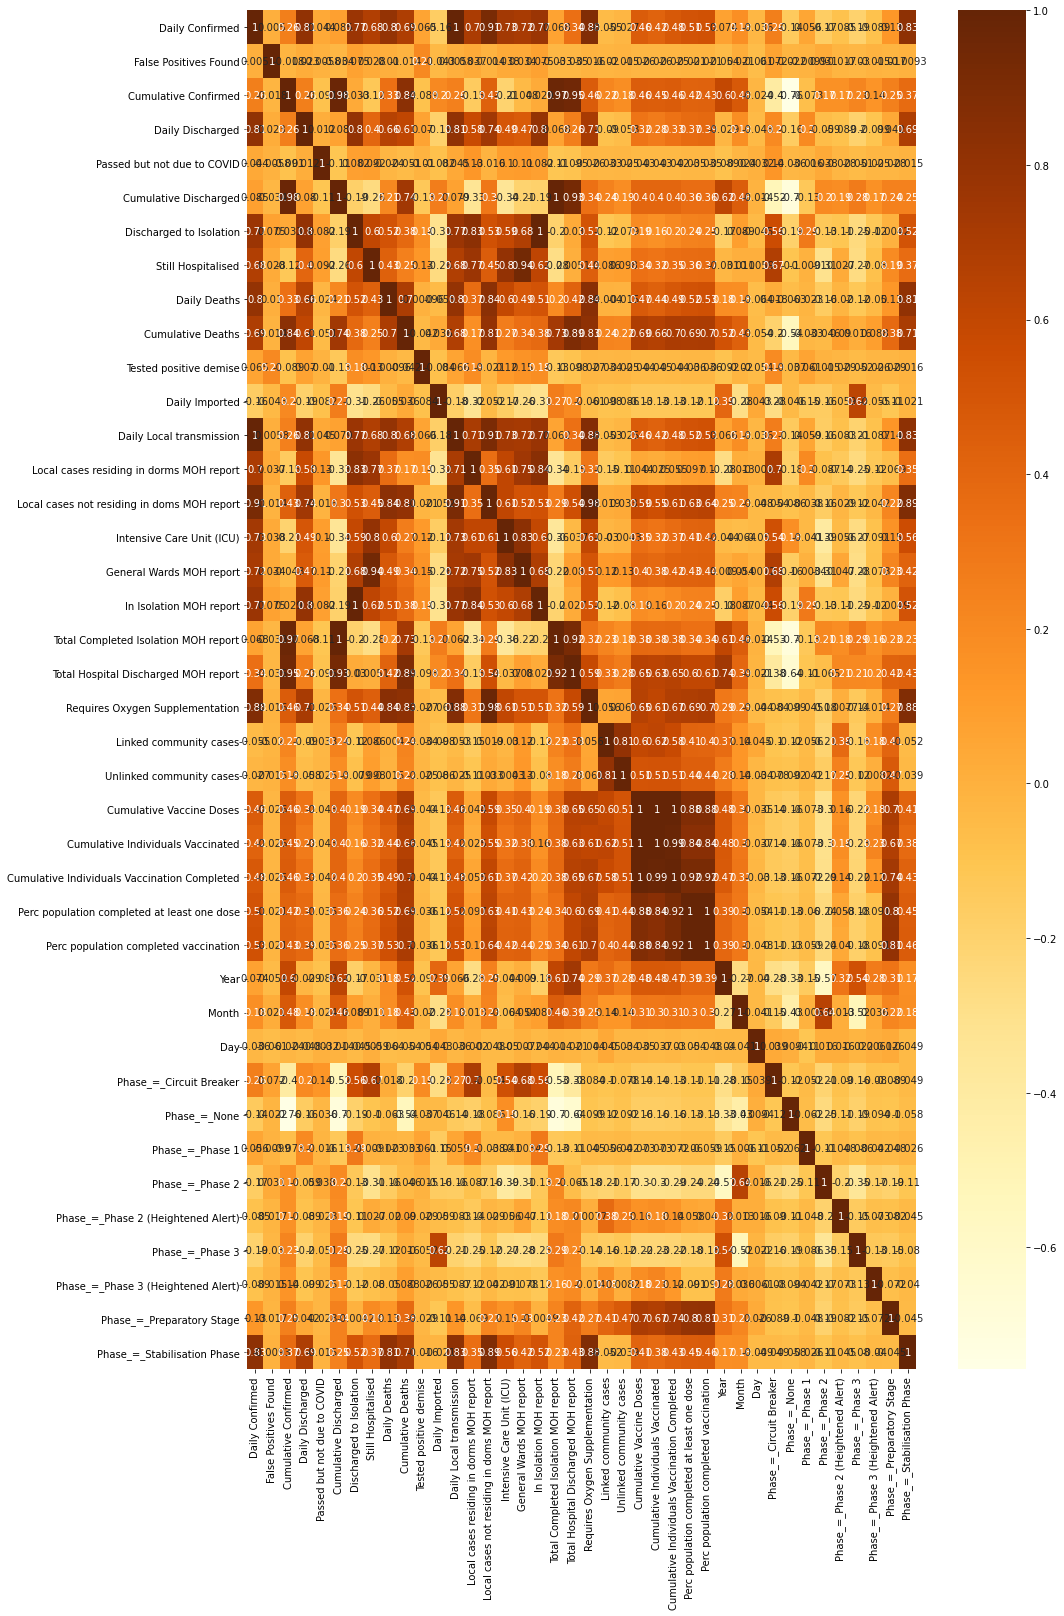

In [15]:
# corr. heatmap

plt.figure(figsize=(15,25))
sns.heatmap(sg_data_filtered.corr(), cmap='YlOrBr', annot=True)

In [17]:
# understanding correlation of all variables to imported cases (can change accordingly to the variable you are trying to predict)

sg_data_filtered.corr()["Daily Confirmed"].sort_values(ascending=False)

Daily Confirmed                                 1.000000
Daily Local transmission                        0.999813
Local cases not residing in doms MOH report     0.912537
Requires Oxygen Supplementation                 0.877891
Phase_=_Stabilisation Phase                     0.827920
Daily Discharged                                0.812171
Daily Deaths                                    0.798768
In Isolation MOH report                         0.770385
Discharged to Isolation                         0.766995
Intensive Care Unit (ICU)                       0.733403
General Wards MOH report                        0.717878
Local cases residing in dorms MOH report        0.701497
Cumulative Deaths                               0.685662
Still Hospitalised                              0.677007
Perc population completed vaccination           0.529944
Perc population completed at least one dose     0.514439
Cumulative Individuals Vaccination Completed    0.481923
Cumulative Vaccine Doses       

In [16]:
# conduct PCA on preprocessed columns

# pca = PCA().fit(sg_data_filtered)

In [17]:
# pca.components_[0]

In [18]:
# find index of columns that make most contribution to variance captured

# include index of Daily Imported first
# important_indices = [11]

# for i in range(len(pca.components_[0])):
#     curr_comp = pca.components_[0][i]
#     if curr_comp > 0.0001:
#         important_indices.append(i)

In [19]:
# select the columns that are positively correlated to imported cases + PCA columns

# sg_data_final = sg_data_filtered.iloc[:, important_indices]

# Train Test Split

In [30]:
# change y variable accordingly to what is of interest

X = sg_data_filtered.drop("Daily Confirmed", axis=1)
y = sg_data_filtered["Daily Confirmed"]

In [31]:
# split using 25% for test as amount of data isn't much so that we've got more points to test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Linear Regression

In [32]:
# build multiple linear regression model

regression = LinearRegression()
regression.fit(X_train, y_train)
pred = regression.predict(X_test)

In [33]:
# assessing model

train_adjusted_r2 = 1 - (1-regression.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-regression.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for LR")
print(f"MAE: {mean_absolute_error(y_test, pred)}")
print(f"MSE: {mean_squared_error(y_test, pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
print(f"R-squared score for train: {regression.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {regression.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for LR
MAE: 1.2588205289542997e-10
MSE: 3.722703575628859e-20
RMSE: 1.9294308942351004e-10
R-squared score for train: 1.0
Adjusted R-squared score for train: 1.0
R-squared score for test: 1.0
Adjusted R-squared score for test: 1.0


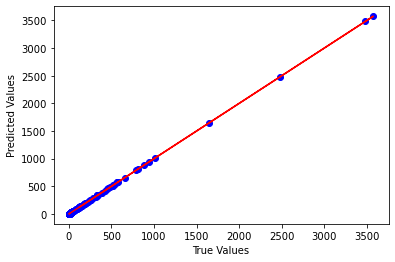

In [34]:
# For test set

# scatter for predictions
plt.scatter(y_test, pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

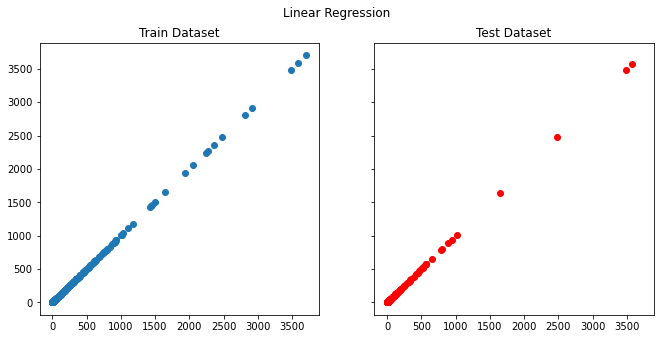

In [35]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(regression.predict(X_train), y_train)
ax[1].scatter(pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Linear Regression')

plt.show()

In [36]:
# find out feature importance

regr_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': regression.coef_
})

regr_importance = regr_importance.sort_values(by='Importance', ascending=False)
regr_importance

,Attribute,Importance
11,Daily Local transmission,1.000000e+00
10,Daily Imported,1.000000e+00
3,Passed but not due to COVID,2.372910e-10
1,Cumulative Confirmed,4.348890e-11
14,Intensive Care Unit (ICU),8.268004e-12
26,Perc population completed vaccination,2.001409e-12
28,Month,1.173162e-12
33,Phase_=_Phase 2,2.406856e-13
31,Phase_=_None,1.012500e-13
35,Phase_=_Phase 3,8.487018e-14


# Lasso Regression

In [37]:
# build lasso model

lasso = Lasso(max_iter=10000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

In [38]:
# assessing model

train_adjusted_r2 = 1 - (1-lasso.score(X_train, y_train)) * (len(y)-1)/(len(y)-X.shape[1]-1)
test_adjusted_r2 = 1 - (1-lasso.score(X_test, y_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print("Evaluation Metrics for Lasso")
print(f"MAE: {mean_absolute_error(y_test, lasso_pred)}")
print(f"MSE: {mean_squared_error(y_test, lasso_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lasso_pred))}")
print(f"R-squared score for train: {lasso.score(X_train, y_train)}")
print(f"Adjusted R-squared score for train: {train_adjusted_r2}")
print(f"R-squared score for test: {lasso.score(X_test, y_test)}")
print(f"Adjusted R-squared score for test: {test_adjusted_r2}")

Evaluation Metrics for Lasso
MAE: 0.5249088338613269
MSE: 2.484814581525442
RMSE: 1.576329464777412
R-squared score for train: 0.9999963492018626
Adjusted R-squared score for train: 0.9999961066445758
R-squared score for test: 0.9999893501694681
Adjusted R-squared score for test: 0.9999886425998076


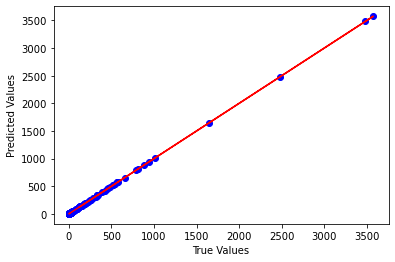

In [39]:
# For test set

# scatter for predictions
plt.scatter(y_test, lasso_pred, color = "blue")
# perfect predictions
plt.plot(y_test, y_test, color = "red")

plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

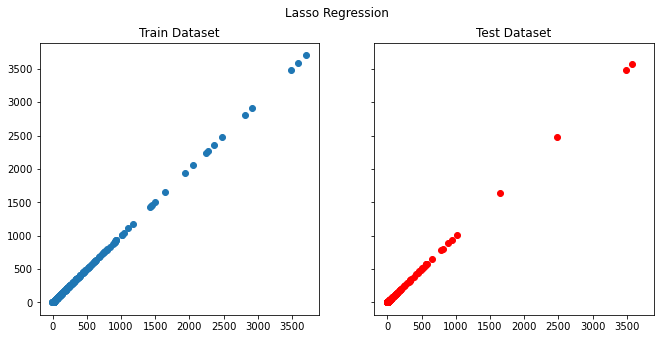

In [40]:
# visualise performance of train vs test

fig, ax = plt.subplots(1, 2, figsize=(11,5), sharey=True, sharex=True)

ax[0].scatter(lasso.predict(X_train), y_train)
ax[1].scatter(lasso_pred, y_test, c = 'red')
ax[0].set_title('Train Dataset')
ax[1].set_title('Test Dataset')

plt.suptitle('Lasso Regression')

plt.show()

In [41]:
# find out feature importance

lasso_importance = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': lasso.coef_
})

lasso_importance = lasso_importance.sort_values(by='Importance', ascending=False)
lasso_importance

,Attribute,Importance
11,Daily Local transmission,9.983313e-01
10,Daily Imported,9.853702e-01
5,Discharged to Isolation,7.094597e-02
6,Still Hospitalised,7.015049e-02
1,Cumulative Confirmed,5.630696e-03
12,Local cases residing in dorms MOH report,2.443736e-03
2,Daily Discharged,2.323931e-05
23,Cumulative Individuals Vaccinated,1.638572e-06
24,Cumulative Individuals Vaccination Completed,7.430343e-08
33,Phase_=_Phase 2,0.000000e+00
